# Training by using the covariance matrix of multihead coherent state generation by pullback

Use the multihead (2-head) gates in the phase space 
to create a network that represent a coherent state,
by starting from a Gaussian state and making a pullback

Use the derivative and the covariance matrix for the training

NOTE: remember to shut down the kernel when out of memory

<img src="../img/complexcoherentCOV.png" width="900" height="300" />

<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 21 sep 2020<br>
@version 15 may 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages

In [2]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float32

Precision for output on the screen

In [4]:
np.set_printoptions(precision=2)

## Dimension

In [5]:
N = 10

## Build vacuum by the Gaussian state

In [6]:
vacuum = ps.VacuumLayer(N)

## Build the pullback layer for generating the input coherent state

The target displacement is a normalized vector

In [7]:
dinput = 3.0*np.ones((N,1)); 
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())

[[0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32]]


Check the normalization of the dtarget

In [8]:
print(np.dot(dinput.transpose(), dinput)) 

[[1.]]


### Build the Displacement layer
The layer is a constant layer, as no training is needed

In [9]:
D = ps.DisplacementLayerConstant(dinput)

## Define the layer for the constant random medium
The LinearConstantMultiHead generate by default a random medium with 
the relevant symplectic operator

In [10]:
R = ps.RandomLayerConstant(N)

## Define the trainable unitary layer

In [11]:
T = ps.RandomLayer(N)

## Define the normalized target displacement vector

In [12]:
dtarget = np.zeros((N,1)); dtarget[0]=1.0; dtarget[1]=0.5;
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm
print(dtarget.transpose())

[[0.89 0.45 0.   0.   0.   0.   0.   0.   0.   0.  ]]


Check the normalization

In [13]:
print(np.dot(dtarget.transpose(), dtarget)) 

[[1.]]


## Define the target covariance matrix

In [14]:
gtarget = np.eye(N);

## Connect the layers

Input layer

In [15]:
xin = tf.keras.layers.Input(N);print(xin)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [16]:
x3, a3 = R(xin)
x2, a2 = T(x3,a3)
x1, a1 = D(x2,a2)
chir, chii = vacuum(x1, a1) 
pullback = tf.keras.Model(inputs = xin, outputs=[chir, chii])

Add the covariance and derivative layer for evaluating the mean <R>

In [17]:
cov_layer = ps.CovarianceLayer(N)
g, Re, _ = cov_layer(chir,chii, pullback)

In [18]:
pullback_cov = tf.keras.Model(inputs = xin, outputs=[g, Re])

### Store the M,d of the LL_complex layer for later chek

In [19]:
M_R_tf, _=R.get_M(); M_R_np=M_R_tf.numpy()

In [20]:
d_R_np=R.d.numpy()

### Store the M, d of the untrained U_train layer for later check

In [21]:
WR_untrained_T = T.WR.numpy()

In [22]:
WI_untrained_T = T.WI.numpy()

In [23]:
M_untrained_T, MI_untrained_T = T.get_M()

## Auxiliary staff

Tensor flow function that returns the gradient

In [24]:
@tf.function
def derivative():
    x = tf.constant(np.zeros((1,N)))
    with tf.GradientTape() as tape:
        tape.watch(x)
        cr, ci = pullback(x)
        chii_x = tape.gradient(ci, x)
    return chii_x

Tensor flow function that returns the covariance matrix

In [25]:
@tf.function
def covariance_matrix():
    x = tf.constant(np.zeros((1,N)))
    with tf.GradientTape(persistent=True) as t1:
        t1.watch(x)
        with tf.GradientTape(persistent=True) as t2:
            t2.watch(x)
            cr, ci = pullback(x)
        cr_x = t2.gradient(cr, x)
        ci_x = t2.gradient(ci, x)
    d2cr= t1.jacobian(cr_x,x)
    # reshape the Jacobian to a matrix
    Hc2 = tf.reshape(d2cr, [N,N])
    # evaluate the covariance with the factor 2.0 to account for the definition of g
    cov = -2*(Hc2+tf.matmul(ci_x,ci_x,transpose_a=True))      
    return cov

## Build the training set by using a target characteristic function

Number of training points
Also a single training point is enough for Gaussian state, more points improve the training

In [26]:
Nbatch = 100

Define the numpy function for the target characteristic function:
    a coherent state with a target displacement
One need a target d for any training points

In [27]:
xtrain = np.random.rand(Nbatch, N)-0.5
Rtrain = np.zeros((Nbatch,N))
gtrain = np.zeros((Nbatch,N,N))
for j in range(Nbatch):
    for i in range(N):
        Rtrain[j,i]=dtarget[i]
        for k in range(N):
            gtrain[j,i,k]=gtarget[i,k]

## Train the model

In [28]:
pullback_cov.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

Summary of the derivative model

In [29]:
pullback_cov.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 random_layer (RandomLayer)     [(None, 10),         50          ['input_1[0][0]']                
                                 (10, 1)]                                                         
                                                                                                  
 random_layer_1 (RandomLayer)   [(None, 10),         50          ['random_layer[0][0]',           
                                 (10, 1)]                         'random_layer[0][1]']           
                                                                                            

Test the call of the derivative layer

In [30]:
pullback_cov(xtrain)

[<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
 array([[ 1.00e+00, -1.49e-07,  3.54e-08, -1.49e-08,  2.97e-07,  3.35e-08,
          1.30e-07, -1.79e-07, -4.13e-07,  7.45e-08],
        [ 8.94e-08,  1.00e+00, -2.24e-08,  5.96e-08, -5.59e-08,  2.83e-07,
          1.64e-07,  1.49e-07, -9.69e-08, -2.98e-07],
        [ 1.04e-07, -8.94e-08,  1.00e+00, -7.45e-09,  1.91e-08, -1.14e-07,
          2.13e-07, -1.75e-07,  4.14e-08, -2.98e-07],
        [-1.49e-08,  5.96e-08, -2.98e-08,  1.00e+00,  1.28e-07, -6.33e-08,
          8.94e-08,  2.09e-07,  3.61e-07, -5.96e-08],
        [ 2.81e-07, -1.01e-07,  1.96e-08,  1.78e-07,  1.00e+00, -6.71e-08,
          2.02e-07,  3.91e-08,  2.94e-07,  6.89e-08],
        [ 4.47e-08,  2.76e-07, -1.47e-07,  1.86e-08,  1.26e-08,  1.00e+00,
         -4.66e-08,  1.79e-07, -1.36e-07,  2.38e-07],
        [ 1.92e-07,  2.91e-07,  2.05e-07,  1.97e-07,  1.93e-07, -5.59e-09,
          1.00e+00,  3.73e-08,  6.05e-09,  1.12e-07],
        [-1.42e-07,  8.94e-08, -1.60e-07,  1.1

## Training of the model

In [31]:
history = pullback_cov.fit(x=xtrain,y=[gtrain, Rtrain], epochs=50, verbose=2)

Epoch 1/50
4/4 - 2s - loss: 0.2728 - covariance_layer_loss: 2.5033e-14 - covariance_layer_1_loss: 0.2728 - 2s/epoch - 586ms/step
Epoch 2/50
4/4 - 0s - loss: 0.2141 - covariance_layer_loss: 2.0212e-14 - covariance_layer_1_loss: 0.2141 - 9ms/epoch - 2ms/step
Epoch 3/50
4/4 - 0s - loss: 0.1537 - covariance_layer_loss: 2.8098e-14 - covariance_layer_1_loss: 0.1537 - 10ms/epoch - 3ms/step
Epoch 4/50
4/4 - 0s - loss: 0.1042 - covariance_layer_loss: 2.4674e-14 - covariance_layer_1_loss: 0.1042 - 10ms/epoch - 3ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0751 - covariance_layer_loss: 3.1646e-14 - covariance_layer_1_loss: 0.0751 - 10ms/epoch - 2ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0663 - covariance_layer_loss: 3.6769e-14 - covariance_layer_1_loss: 0.0663 - 11ms/epoch - 3ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0671 - covariance_layer_loss: 3.4540e-14 - covariance_layer_1_loss: 0.0671 - 12ms/epoch - 3ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0665 - covariance_layer_loss: 3.4968e-14 - covariance_layer_1_loss: 

Text(0.5, 0, 'Epoch')

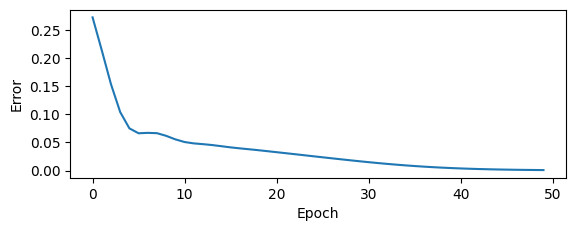

In [32]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epoch')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

Use the derivative function for the derivative

In [33]:
utilities.printonscreen(derivative())

+0.9+0.0i +0.4+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i -0.0+0.0i +0.1+0.0i +0.0+0.0i 


Use the covariance_matrix function for the covariance

In [34]:
utilities.printonscreen(covariance_matrix())

+1.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i 
+0.0+0.0i +1.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i 
+0.0+0.0i +0.0+0.0i +1.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i -0.0+0.0i 
+0.0+0.0i +0.0+0.0i +0.0+0.0i +1.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i 
+0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +1.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i 
+0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i -0.0+0.0i +1.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i 
+0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i -0.0+0.0i +1.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i 
-0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i +1.0+0.0i -0.0+0.0i +0.0+0.0i 
-0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +0.0+0.0i -0.0+0.0i +1.0+0.0i -0.0+0.0i 
+0.0+0.0i -0.0+0.0i -0.0+0.0i -0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i +0.0+0.0i -0.0+0.0i +

Use the model 

In [35]:
pullback_cov(xtrain)

[<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
 array([[ 1.00e+00,  1.19e-07,  3.43e-07,  2.05e-08,  1.22e-07, -7.22e-08,
          1.42e-07, -2.81e-07, -2.91e-07,  1.12e-08],
        [ 5.96e-08,  1.00e+00,  3.73e-08,  2.40e-07,  6.52e-08,  6.24e-08,
          3.32e-07,  6.61e-08, -4.84e-08, -2.89e-07],
        [ 2.24e-07,  4.10e-08,  1.00e+00,  3.14e-09,  1.95e-08, -1.76e-07,
          1.14e-07, -1.08e-07, -1.40e-08, -6.80e-08],
        [ 4.47e-08,  2.67e-07,  3.74e-08,  1.00e+00,  1.49e-07,  4.21e-08,
          1.60e-07,  1.36e-07,  3.38e-08,  1.87e-08],
        [ 1.56e-07,  1.49e-08, -4.81e-08,  1.63e-07,  1.00e+00,  4.78e-08,
         -5.24e-08,  2.17e-07,  7.40e-08,  1.69e-08],
        [ 1.54e-07,  1.59e-07, -1.50e-07, -7.87e-09, -3.83e-08,  1.00e+00,
         -1.88e-07, -4.60e-08,  3.09e-08,  4.11e-08],
        [ 8.20e-08,  2.35e-07,  1.45e-07,  1.80e-07, -3.43e-08, -1.72e-07,
          1.00e+00, -8.91e-09,  1.10e-07,  4.81e-08],
        [-3.20e-07,  1.05e-07, -1.04e-07,  1.0

## Plot the model

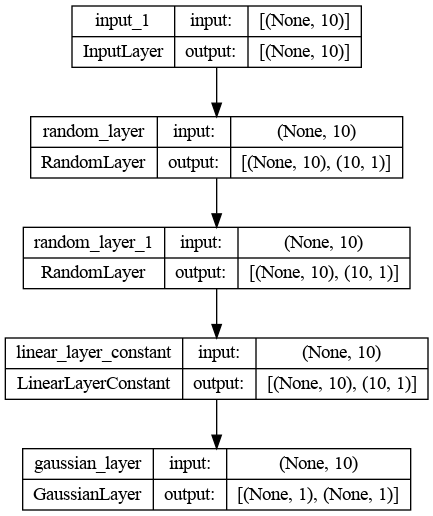

In [36]:
dot_img_file = 'pullback_COV.png'
tf.keras.utils.plot_model(pullback, to_file=dot_img_file, show_shapes=True)

## Check the weights of the layers

### d and M of the complex layer LL_complex (these are unchanged)

In [37]:
print(R.d.numpy().transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [38]:
print(d_R_np.transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [39]:
M_R, _ =R.get_M();print(M_R.numpy())

[[ 0.32  0.13 -0.05  0.4  -0.07  0.45 -0.32  0.61  0.14 -0.15]
 [-0.13  0.32 -0.4  -0.05 -0.45 -0.07 -0.61 -0.32  0.15  0.14]
 [ 0.35  0.31  0.53  0.13  0.05 -0.38 -0.24  0.03 -0.27  0.45]
 [-0.31  0.35 -0.13  0.53  0.38  0.05 -0.03 -0.24 -0.45 -0.27]
 [ 0.18 -0.1  -0.45 -0.24  0.54  0.28 -0.12  0.   -0.18  0.53]
 [ 0.1   0.18  0.24 -0.45 -0.28  0.54 -0.   -0.12 -0.53 -0.18]
 [ 0.08  0.59 -0.39 -0.16 -0.16 -0.22  0.52  0.35 -0.08  0.06]
 [-0.59  0.08  0.16 -0.39  0.22 -0.16 -0.35  0.52 -0.06 -0.08]
 [-0.43  0.27  0.29  0.15 -0.04  0.45  0.25 -0.07  0.34  0.49]
 [-0.27 -0.43 -0.15  0.29 -0.45 -0.04  0.07  0.25 -0.49  0.34]]


In [40]:
print(M_R_np)

[[ 0.32  0.13 -0.05  0.4  -0.07  0.45 -0.32  0.61  0.14 -0.15]
 [-0.13  0.32 -0.4  -0.05 -0.45 -0.07 -0.61 -0.32  0.15  0.14]
 [ 0.35  0.31  0.53  0.13  0.05 -0.38 -0.24  0.03 -0.27  0.45]
 [-0.31  0.35 -0.13  0.53  0.38  0.05 -0.03 -0.24 -0.45 -0.27]
 [ 0.18 -0.1  -0.45 -0.24  0.54  0.28 -0.12  0.   -0.18  0.53]
 [ 0.1   0.18  0.24 -0.45 -0.28  0.54 -0.   -0.12 -0.53 -0.18]
 [ 0.08  0.59 -0.39 -0.16 -0.16 -0.22  0.52  0.35 -0.08  0.06]
 [-0.59  0.08  0.16 -0.39  0.22 -0.16 -0.35  0.52 -0.06 -0.08]
 [-0.43  0.27  0.29  0.15 -0.04  0.45  0.25 -0.07  0.34  0.49]
 [-0.27 -0.43 -0.15  0.29 -0.45 -0.04  0.07  0.25 -0.49  0.34]]


### d and M of the trained layer, before and after training (they must change)

In [41]:
T.WR

<tf.Variable 'random_layer_1/WR:0' shape=(5, 5) dtype=float32, numpy=
array([[-0.18,  0.37,  0.64,  0.43,  0.59],
       [ 0.82,  0.5 ,  1.03,  0.57,  0.75],
       [ 0.77,  0.95,  0.38,  0.83,  0.56],
       [ 0.79, -0.01,  1.12,  1.  ,  0.31],
       [ 0.07,  0.94, -0.14,  0.68, -0.22]], dtype=float32)>

In [42]:
WR_untrained_T

array([[0.04, 0.31, 0.67, 0.11, 0.89],
       [0.75, 0.05, 0.81, 0.74, 0.74],
       [0.8 , 0.73, 0.02, 0.67, 0.82],
       [0.48, 0.15, 0.96, 0.48, 0.32],
       [0.37, 0.93, 0.11, 0.7 , 0.06]], dtype=float32)

In [43]:
T.WI

<tf.Variable 'random_layer_1/WI:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.5 , -0.09, -0.4 ,  0.07,  0.67],
       [ 0.85,  0.3 , -0.68,  0.69,  1.41],
       [ 1.01,  1.99,  0.81,  0.22,  1.28],
       [ 1.37,  0.79,  0.78,  0.88,  0.5 ],
       [ 0.59, -0.51, -0.01,  0.16,  0.47]], dtype=float32)>

In [44]:
WI_untrained_T

array([[0.5 , 0.47, 0.07, 0.9 , 0.41],
       [0.29, 0.3 , 0.33, 0.75, 0.78],
       [0.53, 0.98, 0.81, 0.6 , 0.9 ],
       [0.54, 0.73, 0.4 , 0.88, 0.3 ],
       [0.84, 0.13, 0.37, 0.36, 0.47]], dtype=float32)

In [45]:
M_T, _= T.get_M(); print(M_T)

tf.Tensor(
[[ 0.04  0.54 -0.03 -0.    0.46  0.18  0.33 -0.46 -0.02 -0.37]
 [-0.54  0.04  0.   -0.03 -0.18  0.46  0.46  0.33  0.37 -0.02]
 [ 0.24 -0.45 -0.42 -0.46  0.34  0.12  0.07  0.27  0.03 -0.38]
 [ 0.45  0.24  0.46 -0.42 -0.12  0.34 -0.27  0.07  0.38  0.03]
 [ 0.   -0.21  0.17 -0.55 -0.28 -0.12  0.5  -0.39 -0.25  0.24]
 [ 0.21  0.    0.55  0.17  0.12 -0.28  0.39  0.5  -0.24 -0.25]
 [-0.39 -0.3   0.35 -0.07 -0.11 -0.2  -0.26 -0.29  0.21 -0.62]
 [ 0.3  -0.39  0.07  0.35  0.2  -0.11  0.29 -0.26  0.62  0.21]
 [-0.31 -0.27  0.38 -0.05  0.62  0.31 -0.18 -0.03 -0.23  0.35]
 [ 0.27 -0.31  0.05  0.38 -0.31  0.62  0.03 -0.18 -0.35 -0.23]], shape=(10, 10), dtype=float32)


In [46]:
print(M_untrained_T)

tf.Tensor(
[[ 0.42  0.47 -0.02 -0.22  0.25  0.1  -0.46  0.18  0.3   0.37]
 [-0.47  0.42  0.22 -0.02 -0.1   0.25 -0.18 -0.46 -0.37  0.3 ]
 [-0.12  0.26  0.19  0.66  0.36  0.26 -0.12  0.22  0.08 -0.42]
 [-0.26 -0.12 -0.66  0.19 -0.26  0.36 -0.22 -0.12  0.42  0.08]
 [ 0.38 -0.11 -0.   -0.07  0.05  0.79  0.41  0.01 -0.22  0.09]
 [ 0.11  0.38  0.07 -0.   -0.79  0.05 -0.01  0.41 -0.09 -0.22]
 [-0.09  0.43 -0.23  0.25  0.07 -0.23  0.68  0.09  0.15  0.37]
 [-0.43 -0.09 -0.25 -0.23  0.23  0.07 -0.09  0.68 -0.37  0.15]
 [-0.11 -0.39  0.52  0.29 -0.2   0.07 -0.05  0.25  0.27  0.55]
 [ 0.39 -0.11 -0.29  0.52 -0.07 -0.2  -0.25 -0.05 -0.55  0.27]], shape=(10, 10), dtype=float32)
